In [37]:
import numpy as np
import glob
import os
from models.JetPointNet import PointNetSegmentation


def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels']  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels']  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e']  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

# Setup
os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU
model_path = "saved_model/PointNetModel.keras"

TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

model = PointNetSegmentation(num_points=278, num_classes=1)
model.load_weights(model_path)

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))



In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Data collections
num_points_list = []
accuracies_list = []
random_accuracies_list = []  # For storing random guess accuracies

# Lists to store total true energy and focused particle p_t for later binning
total_true_energy_samples = []
focused_particle_pts = []

# Minimum number of samples per bin to be included in the output
min_samples_per_bin = 0

# Process each file
for npz_file_idx, npz_file in enumerate(npz_files):
    feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_file)
    segmentation_logits = model.predict(feats)
    segmentation_logits = np.squeeze(segmentation_logits, axis=-1)

    for sample_idx in range(len(feats)):
        sample_features = feats[sample_idx]
        energies = tot_labels[sample_idx]
        tot_true_energy = tot_truth_e[sample_idx]

        energy_point_indices = sample_features[:, 6] == 1

        predicted_classes = np.where(segmentation_logits[sample_idx] > 0, 1, 0)
        true_classes = np.where(frac_labels[sample_idx] > 0.5, 1, 0)

        energies_filtered = tot_truth_e[sample_idx][energy_point_indices]
        predicted_classes_filtered = predicted_classes[energy_point_indices]
        true_classes_filtered = true_classes[energy_point_indices]

        # Random guess predictions
        random_predictions = np.random.randint(0, 2, size=true_classes_filtered.shape)

        correct_predictions = predicted_classes_filtered == true_classes_filtered
        correct_random_predictions = random_predictions == true_classes_filtered

        correct_energy = np.sum(np.abs(energies_filtered[correct_predictions]))
        correct_random_energy = np.sum(np.abs(energies_filtered[correct_random_predictions]))

        total_energy = np.sum(np.abs(energies_filtered))

        energy_weighted_accuracy = correct_energy / (total_energy + 1e-5)
        random_energy_weighted_accuracy = correct_random_energy / (total_energy + 1e-5)

        # Collect total true energy and particle p_t for this sample
        total_true_energy_sample = np.sum(energies_filtered)
        focused_particle_pt = sample_features[0, 4]

        total_true_energy_samples.append(total_true_energy_sample)
        focused_particle_pts.append(focused_particle_pt)
        accuracies_list.append(energy_weighted_accuracy)
        random_accuracies_list.append(random_energy_weighted_accuracy)

        print("Sample Index: ", sample_idx)
        print("Total number of cells in sample: ", np.sum(energy_point_indices))
        print("Predicted Count: ", np.sum(predicted_classes_filtered))
        print("True Count: ", np.sum(true_classes_filtered))
        print("Energy Weighted Accuracy: ", energy_weighted_accuracy)
        print("Random Guess Energy Weighted Accuracy: ", random_energy_weighted_accuracy)
        print()

# Creating bins based on the full range of collected data
energy_bins = np.linspace(min(total_true_energy_samples), max(total_true_energy_samples), num=21)
pt_bins = np.linspace(min(focused_particle_pts), max(focused_particle_pts), num=21)

# Dictionaries to accumulate data for the new bins
energy_acc = {bin_edge: [] for bin_edge in energy_bins}
pt_acc = {bin_edge: [] for bin_edge in pt_bins}

random_energy_acc = {bin_edge: [] for bin_edge in energy_bins}  # For random guess accuracies
random_pt_acc = {bin_edge: [] for bin_edge in pt_bins}

# Accumulate data into bins
for i in range(len(accuracies_list)):
    energy_bin_index = np.digitize(total_true_energy_samples[i], energy_bins) - 1
    pt_bin_index = np.digitize(focused_particle_pts[i], pt_bins) - 1

    if 0 <= energy_bin_index < len(energy_bins):
        energy_acc[energy_bins[energy_bin_index]].append(accuracies_list[i])
        random_energy_acc[energy_bins[energy_bin_index]].append(random_accuracies_list[i])
    if 0 <= pt_bin_index < len(pt_bins):
        pt_acc[pt_bins[pt_bin_index]].append(accuracies_list[i])
        random_pt_acc[pt_bins[pt_bin_index]].append(random_accuracies_list[i])


# Calculate and print the mean accuracies for each bin if the bin has at least min_samples_per_bin samples
# Calculate and print the mean accuracies for each bin if the bin has at least min_samples_per_bin samples
print("Mean Weighted Accuracies by Total True Energy Bin:")
for bin_edge in energy_bins:
    if len(energy_acc[bin_edge]) >= min_samples_per_bin:
        print(f"Energy {bin_edge:.2f}:")
        print(f"  Network Accuracy: {np.mean(energy_acc[bin_edge]):.3f}")
        print(f"  Random Guess Accuracy: {np.mean(random_energy_acc[bin_edge]):.3f}")

print("\nMean Weighted Accuracies by Focused Particle p_t Bin:")
for bin_edge in pt_bins:
    if len(pt_acc[bin_edge]) >= min_samples_per_bin:
        print(f"Particle p_t {bin_edge:.2f}:")
        print(f"  Network Accuracy: {np.mean(pt_acc[bin_edge]):.3f}")
        print(f"  Random Guess Accuracy: {np.mean(random_pt_acc[bin_edge]):.3f}")

# Calculate overall mean weighted accuracy
mean_weighted_accuracy = np.mean(accuracies_list)
mean_random_weighted_accuracy = np.mean(random_accuracies_list)
print("\nOverall Mean Weighted Accuracy: ", f"{mean_weighted_accuracy:.3f}")
print("Overall Mean Random Guess Weighted Accuracy: ", f"{mean_random_weighted_accuracy:.3f}")


16/16 [==============================] - 1s 87ms/step
Sample Index:  0
Total number of cells in sample:  60
Predicted Count:  19
True Count:  29
Energy Weighted Accuracy:  0.4547001812466637
Random Guess Energy Weighted Accuracy:  0.4773565048846314

Sample Index:  1
Total number of cells in sample:  47
Predicted Count:  11
True Count:  15
Energy Weighted Accuracy:  0.5395569752178329
Random Guess Energy Weighted Accuracy:  0.09449515895011967

Sample Index:  2
Total number of cells in sample:  92
Predicted Count:  0
True Count:  83
Energy Weighted Accuracy:  0.16633492801869276
Random Guess Energy Weighted Accuracy:  0.30574683652194534

Sample Index:  3
Total number of cells in sample:  105
Predicted Count:  33
True Count:  65
Energy Weighted Accuracy:  0.557076987977972
Random Guess Energy Weighted Accuracy:  0.5880704637603756

Sample Index:  4
Total number of cells in sample:  39
Predicted Count:  39
True Count:  36
Energy Weighted Accuracy:  0.9927638961289836
Random Guess Energy

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


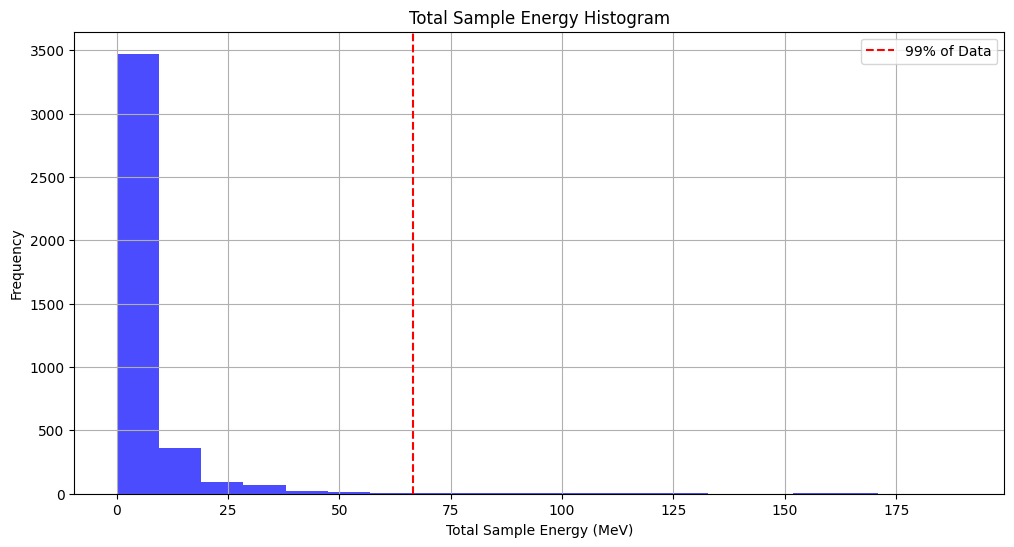

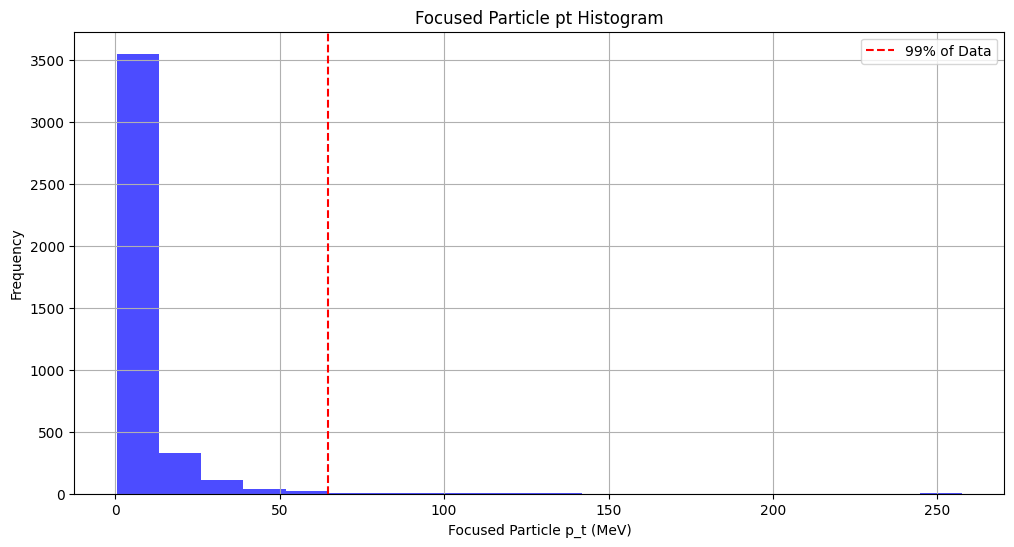

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the histogram frequencies for energy and p_t
energy_histogram, _ = np.histogram(total_true_energy_samples, bins=energy_bins)
pt_histogram, _ = np.histogram(focused_particle_pts, bins=pt_bins)

# Calculate cumulative sums
cumulative_energy = np.cumsum(energy_histogram)
cumulative_pt = np.cumsum(pt_histogram)

total_energy_items = cumulative_energy[-1]
total_pt_items = cumulative_pt[-1]

# Find the bins where cumulative frequency exceeds or reaches 99% of total
energy_99_index = np.where(cumulative_energy >= total_energy_items * 0.99)[0][0]
pt_99_index = np.where(cumulative_pt >= total_pt_items * 0.99)[0][0]

# Centers and widths for the bars in the histogram
energy_centers = [(energy_bins[i] + energy_bins[i+1]) / 2 for i in range(len(energy_bins)-1)]
energy_bin_widths = [energy_bins[i+1] - energy_bins[i] for i in range(len(energy_bins)-1)]
pt_centers = [(pt_bins[i] + pt_bins[i+1]) / 2 for i in range(len(pt_bins)-1)]
pt_bin_widths = [pt_bins[i+1] - pt_bins[i] for i in range(len(pt_bins)-1)]

# Plotting Histogram for Energy
plt.figure(figsize=(12, 6))
plt.bar(energy_centers, energy_histogram, width=energy_bin_widths, align='center', color='blue', alpha=0.7)
plt.axvline(x=energy_bins[energy_99_index + 1], color='red', linestyle='--', label='99% of Data')
plt.xlabel('Total Sample Energy (MeV)')
plt.ylabel('Frequency')
plt.title('Total Sample Energy Histogram')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Histogram for Particle p_t
plt.figure(figsize=(12, 6))
plt.bar(pt_centers, pt_histogram, width=pt_bin_widths, align='center', color='blue', alpha=0.7)
plt.axvline(x=pt_bins[pt_99_index + 1], color='red', linestyle='--', label='99% of Data')
plt.xlabel('Focused Particle p_t (MeV)')
plt.ylabel('Frequency')
plt.title('Focused Particle pt Histogram')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


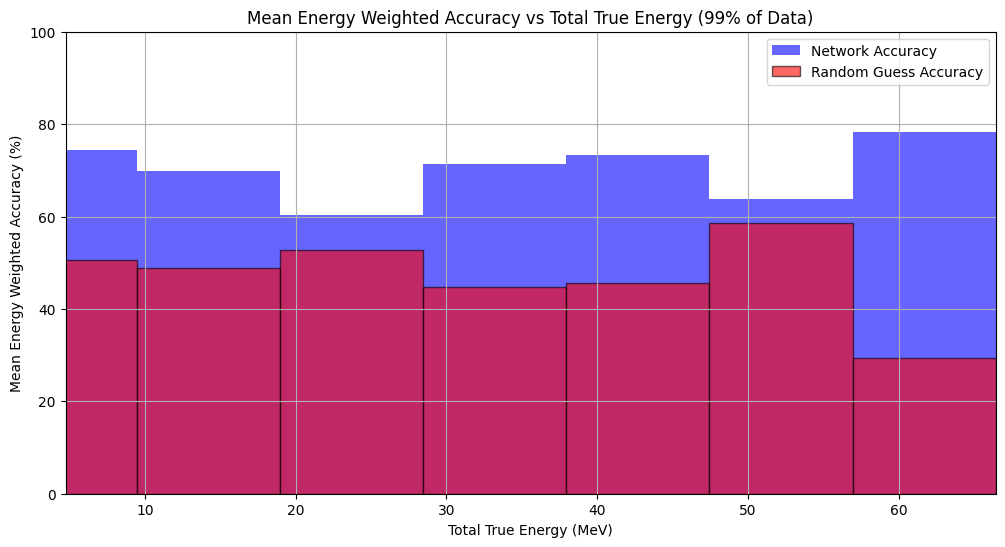

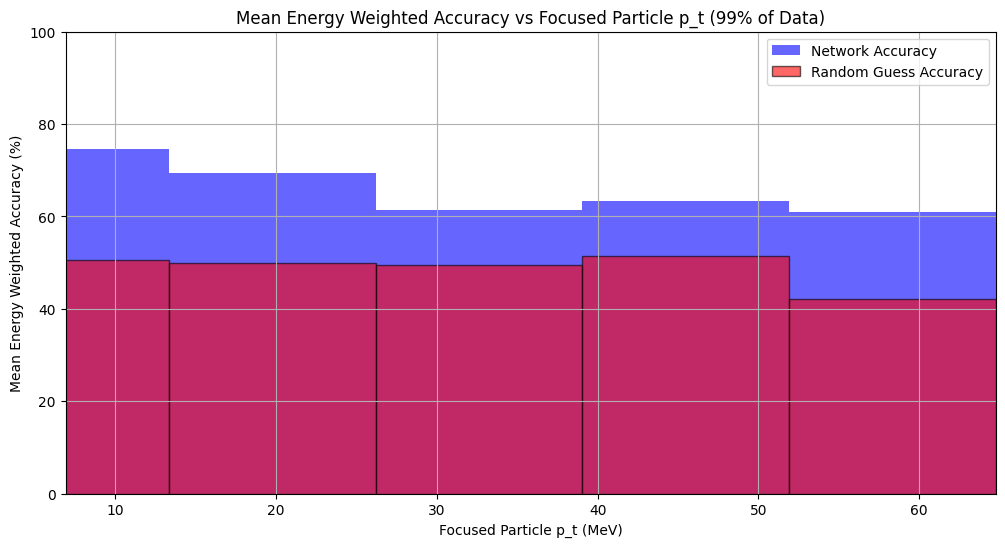

In [63]:
import matplotlib.pyplot as plt
import numpy as np

min_samples_per_bin = 0


# Prepare the data for plotting
energy_centers = [(energy_bins[i] + energy_bins[i+1]) / 2 for i in range(len(energy_bins)-1)]
energy_bin_widths = [energy_bins[i+1] - energy_bins[i] for i in range(len(energy_bins)-1)]
network_acc_energy = [np.mean(energy_acc[bin])*100 if len(energy_acc[bin]) >= min_samples_per_bin else None for bin in energy_bins[:-1]]
random_acc_energy = [np.mean(random_energy_acc[bin])*100 if len(random_energy_acc[bin]) >= min_samples_per_bin else None for bin in energy_bins[:-1]]

pt_centers = [(pt_bins[i] + pt_bins[i+1]) / 2 for i in range(len(pt_bins)-1)]
pt_bin_widths = [pt_bins[i+1] - pt_bins[i] for i in range(len(pt_bins)-1)]
network_acc_pt = [np.mean(pt_acc[bin])*100 if len(pt_acc[bin]) >= min_samples_per_bin else None for bin in pt_bins[:-1]]
random_acc_pt = [np.mean(random_pt_acc[bin])*100 if len(random_pt_acc[bin]) >= min_samples_per_bin else None for bin in pt_bins[:-1]]

# Filter to include only bins with data for adjusting x-axis range
valid_energy_centers = [center for center, acc in zip(energy_centers, network_acc_energy) if acc is not None]
if valid_energy_centers:
    min_energy_x = min(valid_energy_centers)
    max_energy_x = max(valid_energy_centers)
else:
    min_energy_x, max_energy_x = min(energy_centers), max(energy_centers)  # Fallback to full range if no valid centers

valid_pt_centers = [center for center, acc in zip(pt_centers, network_acc_pt) if acc is not None]
if valid_pt_centers:
    min_pt_x = min(valid_pt_centers)
    max_pt_x = max(valid_pt_centers)
else:
    min_pt_x, max_pt_x = min(pt_centers), max(pt_centers)  # Fallback to full range if no valid centers

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting, filter out None values and ensure all values are numeric
valid_energy_indices = [i for i, acc in enumerate(network_acc_energy) if acc is not None and i <= energy_99_index]
valid_energy_centers = [energy_centers[i] for i in valid_energy_indices]
valid_energy_bin_widths = [energy_bin_widths[i] for i in valid_energy_indices]
valid_network_acc_energy = [network_acc_energy[i] for i in valid_energy_indices]
valid_random_acc_energy = [random_acc_energy[i] for i in valid_energy_indices]

valid_pt_indices = [i for i, acc in enumerate(network_acc_pt) if acc is not None and i <= pt_99_index]
valid_pt_centers = [pt_centers[i] for i in valid_pt_indices]
valid_pt_bin_widths = [pt_bin_widths[i] for i in valid_pt_indices]
valid_network_acc_pt = [network_acc_pt[i] for i in valid_pt_indices]
valid_random_acc_pt = [random_acc_pt[i] for i in valid_pt_indices]

# Plotting Energy vs Accuracy
plt.figure(figsize=(12, 6))
plt.bar(valid_energy_centers, valid_network_acc_energy, width=valid_energy_bin_widths, align='center', alpha=0.6, label='Network Accuracy', color='blue')
plt.bar(valid_energy_centers, valid_random_acc_energy, width=valid_energy_bin_widths, align='center', alpha=0.6, label='Random Guess Accuracy', color='red', edgecolor='black')
plt.xlabel('Total Sample Energy (MeV)')
plt.ylabel('Mean Energy Weighted Accuracy (%)')
plt.title('Mean Energy Weighted Accuracy vs Total Sample Energy (99% of Data)')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)  # Setting the y-axis from 0% to 100%
plt.xlim(min(valid_energy_centers), energy_bins[energy_99_index + 1])  # Adjusting x-axis based on data availability
plt.show()

# Plotting Pt vs Accuracy
plt.figure(figsize=(12, 6))
plt.bar(valid_pt_centers, valid_network_acc_pt, width=valid_pt_bin_widths, align='center', alpha=0.6, label='Network Accuracy', color='blue')
plt.bar(valid_pt_centers, valid_random_acc_pt, width=valid_pt_bin_widths, align='center', alpha=0.6, label='Random Guess Accuracy', color='red', edgecolor='black')
plt.xlabel('Focused Particle p_t (MeV)')
plt.ylabel('Mean Energy Weighted Accuracy (%)')
plt.title('Mean Energy Weighted Accuracy vs Focused Particle p_t (99% of Data)')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)  # Setting the y-axis from 0% to 100%
plt.xlim(min(valid_pt_centers), pt_bins[pt_99_index + 1])  # Adjusting x-axis to cover up to 99% of the items
plt.show()

